<h1> Task_C_3a_i </h1>
<br>
<h2>Streaming Data Visualization</h2>
<br>
<p>For   the   incoming   climate   data we have   plotted   the   line   graph   of   air   temperature  
against   arrival   time.   We  have labeled   minimum and maximum   points  </p>

<IPython.core.display.Javascript object>


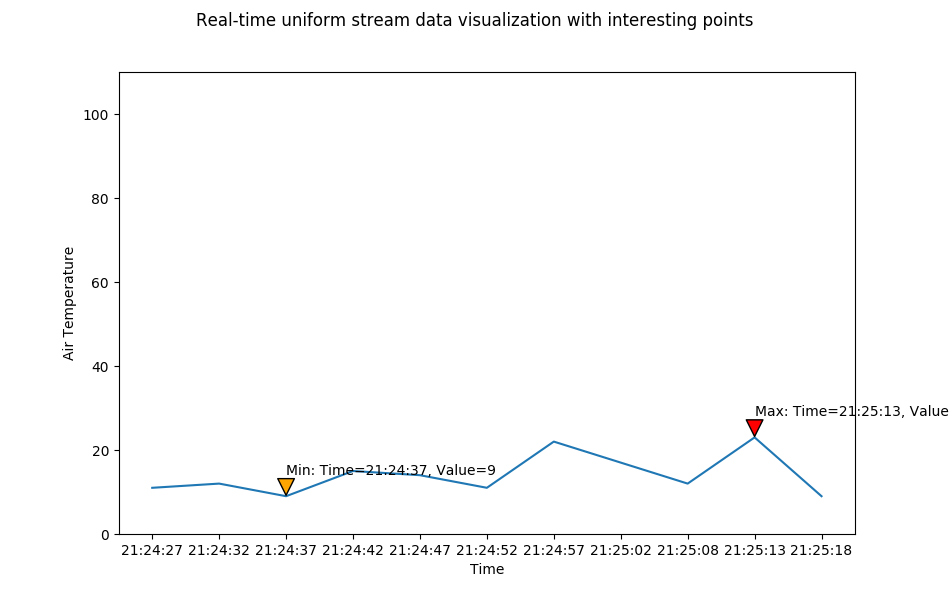

In [2]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'climate'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   #auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Air Temparature')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = str(message.value.decode('utf-8')).split(', ')
            
            if data[len(data) -1] == 'Climate':
#                 print(data)
                x.append(str(dt.datetime.now().strftime("%X"))) 
                y.append(int(data[4]))
                # print(y)
                # we start plotting only when we have 10 data points
                if len(y) > 10:
                    ax.clear()
                    ax.plot(x, y)
                    ax.set_xlabel('Time')
                    ax.set_ylabel('Air Temperature')
                    ax.set_ylim(0,110) 
                    ax.set_yticks([0,20,40,60,80,100])
                    annotate_max(x,y)
                    annotate_min(x,y)
                    fig.canvas.draw()
                    x.pop(0) # removing the item in the first position
                    y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    consumer.close()
    
    

<h1> Task_C_3b_i </h1>
<br>
<h2>Static Data Visualization</h2>
<br>
<p>

In [3]:
from pprint import pprint
from pymongo import MongoClient
client = MongoClient()
db = client.climate_streaming
assignment = db.assignment

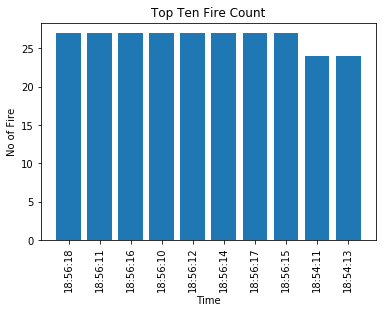

In [4]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
results = assignment.aggregate([
    {"$group" : {"_id":"$time","count":{"$sum":1}}},
    {"$sort" : { "count" : -1}},
    {"$limit":10}
    
])
x = []
y = []
for doc in results:
    x.append(doc['_id'].replace("/'","").strip())
    y.append(doc['count'])
    
    
# this is for plotting purpose


y_pos = np.arange(len(x))
plt.bar(y_pos, y, align='center')
plt.xticks(y_pos, x,rotation="vertical")
plt.ylabel('No of Fire')
plt.xlabel("Time")

plt.title('Top Ten Fire Count')

plt.show()

<h1> Task_C_3b_ii </h1>
<br>
<h2>Static Data Visualization</h2>
<br>
<p>

In [6]:
results = assignment.find()
hotspot_list= []
for i in results:
    if(len(i['climate_hotspot'])>1):

        hotspot_list.append((float(i['latitude']),float(i['longitude']),
                             float(i['climate_hotspot']['surface_temperature_celcious']),
                           float(i['climate_hotspot']['confidence']),
                             float(i["air_temperature_celcious"]),
                             float(i["relative_humidity"])))

In [7]:
import gmplot
# The step below is required by the gmap scatter function to prepare data in correct format
unoccupied_lats, unoccupied_lons,surface_temperature_celcious,confidence,air_temperature_celcious,relative_humidity= zip(*hotspot_list) 

# Plotting the points on the map

# gmplot contains a simple wrapper around 
# Google’s geocoding service enabling map initilization to the location of your choice.

gmap = gmplot.GoogleMapPlotter(unoccupied_lats[0], unoccupied_lons[0], 7)
for i in range(len(unoccupied_lats)):
    text = 'surface_temperature: '+str(surface_temperature_celcious[i]) + ',confidence: '+str(confidence[i])+', air_temperature: '+str(air_temperature_celcious[i])+', relative_humidity: '+ str(relative_humidity[i])
 
    gmap.marker(unoccupied_lats[i], unoccupied_lons[i], title= text)

In [8]:
import webbrowser
# Drawing the map
gmap.draw("fireData.html")
webbrowser.open_new("fireData.html")

True